In [185]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [496]:
def setup_molecular_db(fl="/home/mart/auger/data/Atm_Molecular_1_A.sqlite"):
    import sqlite3
    con = sqlite3.connect(fl)
    return con

con = setup_molecular_db()

In [542]:
def query_database_molecular_profile_gdas(gpssec, con):
    # Takes the closest entry to gpssec 
    #returns dataframe with all 
    query = (f"SELECT molecular_id FROM molecular WHERE start_time = (SELECT MAX(start_time) "
             f"FROM molecular WHERE profile_type_id = {ptype} AND start_time <= {gpssec}"
             f" AND end_time >= {gpssec}) AND profile_type_id = {ptype}"
             f" ORDER BY last_modified DESC LIMIT 1")
    cursor = con.cursor()
    molecular_id = cursor.execute(query).fetchone()
    if molecular_id is None:
        raise IndexError("Could not find id for", gpssec)
    molecular_id = molecular_id[0]
    df = pd.read_sql_query(f"SELECT * FROM molecular_layer WHERE molecular_zone_id = {molecular_id}", con)
    df['log_height'] = np.log(df['height'])
    df['log_depth'] = np.log(df['depth'])
    df = df.sort_values(by='height')
    return df

def get_depth_from_height_table(height, df, zenith=0):
    return np.exp(np.interp(np.log(height), df['log_height'], df['log_depth']))/np.cos(zenith)

def get_height_from_depth_table(depth, df, zenith=0):
    return np.exp(np.interp(np.log(depth*np.cos(zenith)), df['log_depth'][::-1], df['log_height'][::-1]))

1163417122


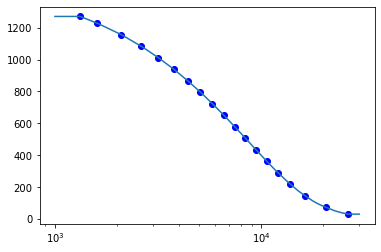

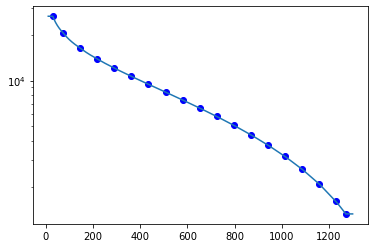

In [585]:
gpssec = np.random.randint(df.query('start_time > 0 & profile_type_id == 1')['start_time'].min(), df.query('start_time > 0 & profile_type_id == 1')['start_time'].max())
print(gpssec)
theta = np.deg2rad(45)
df_id = query_database_molecular_profile_gdas(gpssec, con)
plt.plot(df_id['height'], df_id['depth']/np.cos(theta), 'bo')
h = np.linspace(1000, 30000, 1000)
plt.plot(h, get_depth_from_height_table(h, df_id, theta))
# plt.yscale('log')
plt.xscale('log')

depth = np.linspace(10, 1300, 10000)
plt.figure()
plt.plot(df_id['depth']/np.cos(theta), df_id['height'], 'bo')
plt.plot(depth, get_height_from_depth_table(depth, df_id, theta))
plt.yscale('log')

In [555]:
get_depth_from_height_table(1400, df_id, 0)

881.5600000000001

In [569]:
get_height_from_depth_table(880, df_id, np.deg2rad(30))

2619.5405333332656

In [482]:
%timeit -n 10  query_database_molecular_profile_gdas(gpssec, con)

23.6 ms ± 732 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


880.5311657976372

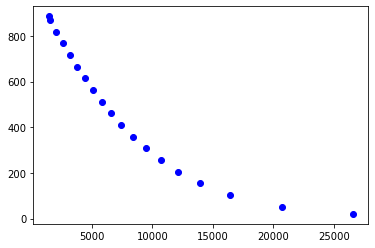

In [486]:
plt.plot(df_id['height'], df_id['depth'], 'bo')
np.interp(1452, df_id['height'], df_id['depth'])